# PART 1D: ROOT CAUSE ANALYSIS - What DRIVES Goals?

## Objective
Find ROOT CAUSES of goals (not just "scoring more = winning more") to:
1. Weight composite scores by correlation strength
2. Build match prediction features  
3. Identify actionable tactical insights

## Data
- 5 seasons (2020-2025) at GW38
- 100 team-seasons
- Pearson correlations

## Design
- **Analysis 1**: Our offense → Our goals
- **Analysis 2**: Opponent offense → Our goals_against

## Section 1: Setup

In [1]:
import duckdb
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

OUTPUT_DIR = Path("../../outputs/04_individual_stats")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("=" * 80)
print("PART 1D: ROOT CAUSE ANALYSIS")
print("=" * 80)
print(f"⏰ Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

PART 1D: ROOT CAUSE ANALYSIS
⏰ Started: 2025-10-19 20:50:51


## Section 2: Load Data

In [2]:
conn = duckdb.connect('../../../data/premierleague_analytics.duckdb')

squad_df = conn.execute("""
    SELECT * FROM analytics_squads
    WHERE season IN ('2020-2021', '2021-2022', '2022-2023', '2023-2024', '2024-2025')
      AND gameweek = 38
""").fetchdf()

opponent_df = conn.execute("""
    SELECT * FROM analytics_opponents
    WHERE season IN ('2020-2021', '2021-2022', '2022-2023', '2023-2024', '2024-2025')
      AND gameweek = 38
""").fetchdf()

opponent_df['squad_name_clean'] = opponent_df['squad_name'].str.replace('vs ', '', regex=False)

# Calculate tiers
squad_df['points'] = (squad_df['wins'] * 3) + squad_df['draws']
squad_df['goal_difference'] = squad_df['goals'] - squad_df['goals_against']
squad_df['final_position'] = squad_df.groupby('season')['points'].rank(method='min', ascending=False).astype(int)
squad_df['tier'] = squad_df['final_position'].apply(lambda p: 'Top 4' if p <= 4 else ('Mid-Table' if p <= 17 else 'Relegation'))

print(f"✅ Loaded {len(squad_df)} squads, {len(opponent_df)} opponents")
print(f"   Tiers: {dict(squad_df['tier'].value_counts())}")

✅ Loaded 100 squads, 100 opponents
   Tiers: {'Mid-Table': 65, 'Top 4': 20, 'Relegation': 15}


## Section 3: Define Stat Exclusions (Avoid Circular Reasoning)

In [ ]:
goal_exclusions = [
    'goals', 'goals_per_90', 'non_penalty_goals', 'non_penalty_goals_per_90', 'goal_difference', 'points',
    'penalty_kicks_made', 'penalty_kicks_attempted',
    'assists', 'assists_per_90', 'assists_passing',
    'goals_plus_assists', 'goals_plus_assists_per_90', 'goals_plus_assists_minus_pks_per_90',
    'expected_goals', 'expected_goals_per_90', 'non_penalty_expected_goals', 'non_penalty_xg_per_90',
    'expected_assisted_goals', 'expected_assisted_goals_per_90',
    'xg_plus_xag_per_90', 'non_penalty_xg_plus_xag', 'non_penalty_xg_plus_xag_per_90',
    'goals_per_shot', 'goals_per_shot_on_target', 'goals_minus_expected', 'non_penalty_goals_minus_expected',
    'goal_creating_actions', 'goal_creating_actions_per_90',
    'gca_pass_live', 'gca_pass_dead', 'gca_take_on', 'gca_shot', 'gca_defense', 'gca_fouled'
]

goals_against_exclusions = [
    'goals_against', 'goals_against_per_90', 'clean_sheets', 'clean_sheet_percentage',
    'saves', 'save_percentage', 'shots_on_target_against',
    'post_shot_expected_goals', 'post_shot_xg_per_shot',
    'post_shot_xg_performance', 'post_shot_xg_performance_per_90'
]

metadata = ['squad_name', 'season', 'gameweek', 'is_current', 'age', 'matches_played', 'wins', 'draws', 'losses']
predictors = [c for c in squad_df.columns
             if c not in metadata + goal_exclusions + goals_against_exclusions
             and squad_df[c].dtype in ['int64', 'float64']]

print(f"✅ Analyzing {len(predictors)} predictors")
print(f"   Excluded {len(goal_exclusions)} circular stats (goals, assists, xG)")

✅ Analyzing 131 predictors
   Excluded 33 circular stats (goals, assists, xG)


## Section 4: Analysis 1 - What Drives Goals SCORED?

In [4]:
print("=" * 80)
print("ANALYSIS 1: WHAT DRIVES GOALS SCORED?")
print("=" * 80)

goals_results = []
for stat in predictors:
    valid = squad_df[[stat, 'goals']].dropna()
    if len(valid) < 10 or valid[stat].std() == 0:
        continue
    r, p = pearsonr(valid[stat], valid['goals'])
    goals_results.append({'stat': stat, 'r': r, 'p': p, 'abs_r': abs(r)})

goals_df = pd.DataFrame(goals_results).sort_values('abs_r', ascending=False)
print(f"\n✅ {len(goals_df)} correlations calculated")

print(f"\nTOP 10 DRIVERS:")
for i, row in goals_df.head(10).iterrows():
    strength = '🔥🔥🔥' if row['abs_r'] >= 0.8 else '🔥🔥' if row['abs_r'] >= 0.6 else '💪'
    print(f"  {row['stat']:<45} r = {row['r']:>6.3f}  {strength}")

ANALYSIS 1: WHAT DRIVES GOALS SCORED?

✅ 128 correlations calculated

TOP 10 DRIVERS:
  goal_difference                               r =  0.912  🔥🔥🔥
  points                                        r =  0.889  🔥🔥🔥
  shots_on_target_per_90                        r =  0.889  🔥🔥🔥
  shots_on_target                               r =  0.889  🔥🔥🔥
  final_position                                r = -0.845  🔥🔥🔥
  touches_att_penalty                           r =  0.838  🔥🔥🔥
  shot_creating_actions                         r =  0.834  🔥🔥🔥
  shot_creating_actions_per_90                  r =  0.834  🔥🔥🔥
  sca_pass_live                                 r =  0.820  🔥🔥🔥
  shots_per_90                                  r =  0.820  🔥🔥🔥


## Section 5: Analysis 2 - What Drives Goals AGAINST?

In [5]:
print("=" * 80)
print("ANALYSIS 2: WHAT DRIVES GOALS AGAINST?")
print("=" * 80)

merged_opp = pd.merge(
    squad_df[['season', 'squad_name', 'goals_against', 'tier']],
    opponent_df[['season', 'squad_name_clean'] + [c for c in predictors if c in opponent_df.columns]],
    left_on=['season', 'squad_name'],
    right_on=['season', 'squad_name_clean'],
    suffixes=('', '_opp')
)

opp_results = []
for stat in predictors:
    if stat not in merged_opp.columns:
        continue
    valid = merged_opp[[stat, 'goals_against']].dropna()
    if len(valid) < 10 or valid[stat].std() == 0:
        continue
    r, p = pearsonr(valid[stat], valid['goals_against'])
    opp_results.append({'stat': f"OPP_{stat}", 'source': 'opponent', 'r': r, 'p': p, 'abs_r': abs(r)})

defense_df = pd.DataFrame(opp_results).sort_values('abs_r', ascending=False)
print(f"\n✅ {len(defense_df)} opponent correlations calculated")

print(f"\nTOP 10 DEFENSIVE DRIVERS:")
for i, row in defense_df.head(10).iterrows():
    strength = '🔥🔥🔥' if row['abs_r'] >= 0.8 else '🔥🔥' if row['abs_r'] >= 0.6 else '💪'
    print(f"  {row['stat']:<45} r = {row['r']:>6.3f}  {strength}")

ANALYSIS 2: WHAT DRIVES GOALS AGAINST?

✅ 125 opponent correlations calculated

TOP 10 DEFENSIVE DRIVERS:
  OPP_shots_on_target                           r =  0.852  🔥🔥🔥
  OPP_shots_on_target_per_90                    r =  0.851  🔥🔥🔥
  OPP_touches_att_penalty                       r =  0.793  🔥🔥
  OPP_key_passes                                r =  0.791  🔥🔥
  OPP_shots_per_90                              r =  0.791  🔥🔥
  OPP_shots                                     r =  0.791  🔥🔥
  OPP_shot_creating_actions                     r =  0.790  🔥🔥
  OPP_shot_creating_actions_per_90              r =  0.790  🔥🔥
  OPP_sca_pass_live                             r =  0.755  🔥🔥
  OPP_passes_penalty_area                       r =  0.753  🔥🔥


## Section 6: Category-Level Analysis

### 6.1 Categorize Stats

In [6]:
# Categorize stats by type
def categorize_stat(stat):
    stat_lower = stat.lower()
    
    if any(x in stat_lower for x in ['shot', 'touch_att_pen']):
        return 'attacking_output'
    elif any(x in stat_lower for x in ['key_pass', 'sca_', 'corner', 'through_ball', 'cross']):
        return 'creativity'
    elif any(x in stat_lower for x in ['pass_complet', 'pass_attempt', 'pass_distance', 'progressive_pass']):
        return 'passing'
    elif any(x in stat_lower for x in ['carry', 'progressive_carri', 'progressive_passes_received', 'take_on']):
        return 'ball_progression'
    elif any(x in stat_lower for x in ['tackle', 'interception', 'block', 'clearance']):
        return 'defending'
    elif any(x in stat_lower for x in ['touch', 'possession']):
        return 'possession'
    elif any(x in stat_lower for x in ['aerial', 'duel', 'foul']):
        return 'physical_duels'
    elif any(x in stat_lower for x in ['error', 'miscontr', 'dispossess', 'challenge_lost']):
        return 'failures'
    else:
        return 'other'

goals_df['category'] = goals_df['stat'].apply(categorize_stat)

# Calculate category-level stats
category_stats = goals_df.groupby('category').agg({
    'abs_r': ['mean', 'max'],
    'stat': 'count'
}).round(3)

category_stats.columns = ['avg_r', 'max_r', 'n_stats']
category_stats = category_stats.sort_values('avg_r', ascending=False)

print("=" * 80)
print("CATEGORY ANALYSIS - Which Stat Types Matter Most?")
print("=" * 80)
print()
print(category_stats)
print()
print(f"💡 {category_stats.index[0]}: Strongest average correlation (r = {category_stats.iloc[0]['avg_r']:.3f})")
print(f"💡 {category_stats.index[-1]}: Weakest predictor (r = {category_stats.iloc[-1]['avg_r']:.3f})")

CATEGORY ANALYSIS - Which Stat Types Matter Most?

                  avg_r  max_r  n_stats
category                               
attacking_output  0.680  0.889       11
passing           0.636  0.802        9
possession        0.590  0.838        7
other             0.423  0.912       54
creativity        0.392  0.820       18
ball_progression  0.378  0.713        8
physical_duels    0.367  0.614        5
defending         0.353  0.599       13
failures          0.155  0.281        3

💡 attacking_output: Strongest average correlation (r = 0.680)
💡 failures: Weakest predictor (r = 0.155)


### 6.2 Visualize Category Correlations

✅ Saved: category_correlations.png


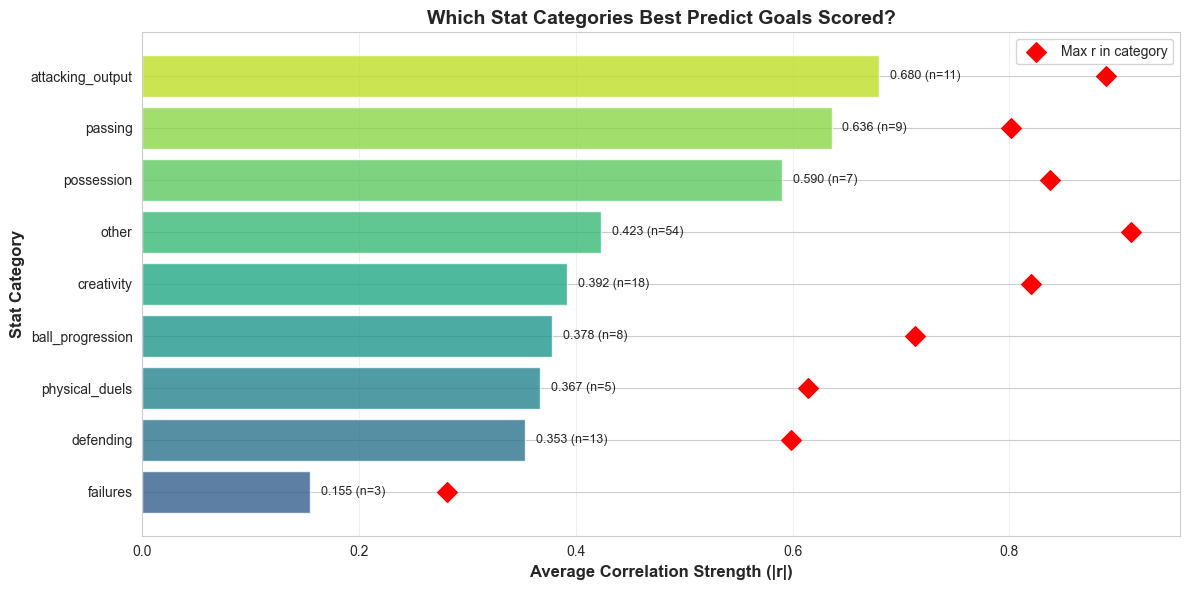

In [7]:
# Bar chart of category strengths
fig, ax = plt.subplots(figsize=(12, 6))

category_plot = category_stats.sort_values('avg_r', ascending=True)
colors_cat = plt.cm.viridis(np.linspace(0.3, 0.9, len(category_plot)))

bars = ax.barh(category_plot.index, category_plot['avg_r'], color=colors_cat, alpha=0.8)

# Add max_r markers
ax.scatter(category_plot['max_r'], range(len(category_plot)), 
          color='red', s=100, marker='D', label='Max r in category', zorder=5)

ax.set_xlabel('Average Correlation Strength (|r|)', fontsize=12, fontweight='bold')
ax.set_ylabel('Stat Category', fontsize=12, fontweight='bold')
ax.set_title('Which Stat Categories Best Predict Goals Scored?', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(category_plot.iterrows()):
    ax.text(row['avg_r'] + 0.01, i, f"{row['avg_r']:.3f} (n={int(row['n_stats'])})", 
           va='center', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "category_correlations.png", dpi=300, bbox_inches='tight')
print("✅ Saved: category_correlations.png")
plt.show()

## Section 7: Visualize Top Drivers

### 7.1 Offensive Drivers Scatter Plots

✅ Saved: scatter_offensive_drivers.png


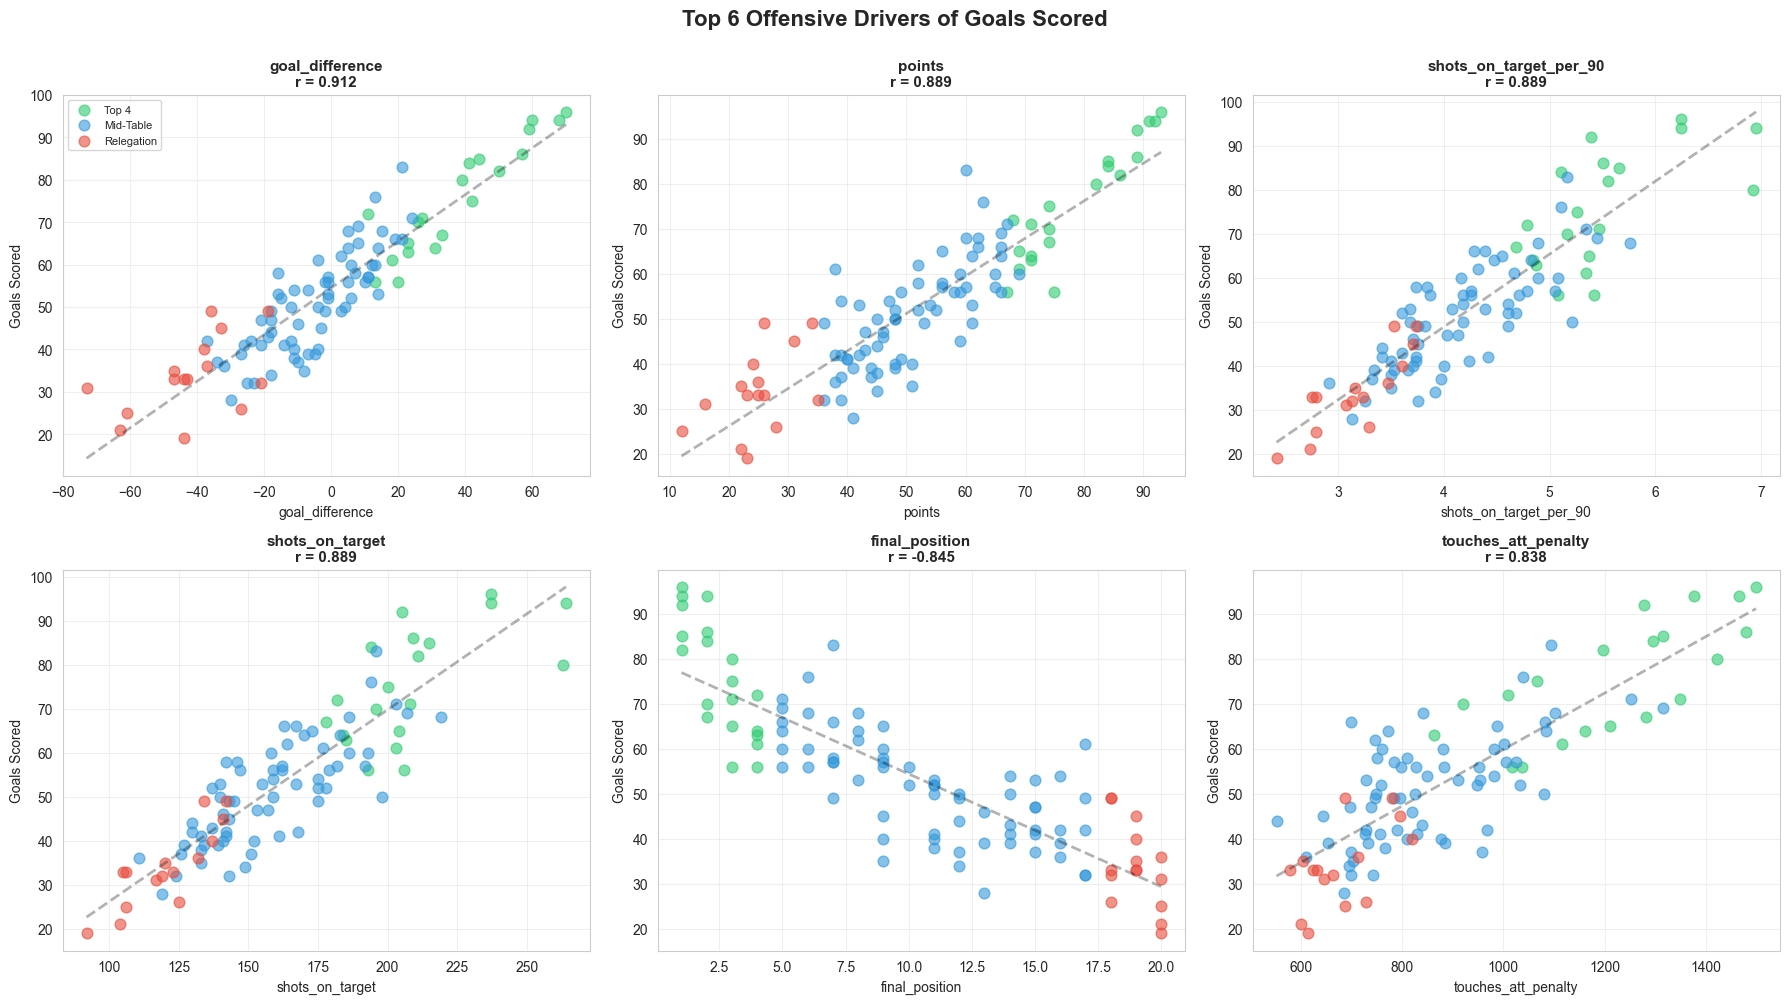

In [8]:
# Create scatter plots for top 6 offensive drivers
top_drivers = goals_df.head(6)['stat'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

tier_colors = {'Top 4': '#2ecc71', 'Mid-Table': '#3498db', 'Relegation': '#e74c3c'}

for idx, stat in enumerate(top_drivers):
    ax = axes[idx]
    
    # Plot by tier
    for tier in ['Top 4', 'Mid-Table', 'Relegation']:
        data = squad_df[squad_df['tier'] == tier]
        ax.scatter(data[stat], data['goals'], 
                  label=tier, alpha=0.6, s=60, color=tier_colors[tier])
    
    # Add regression line
    valid = squad_df[[stat, 'goals']].dropna()
    if len(valid) > 0 and valid[stat].std() > 0:
        z = np.polyfit(valid[stat], valid['goals'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(valid[stat].min(), valid[stat].max(), 100)
        ax.plot(x_line, p(x_line), 'k--', alpha=0.3, linewidth=2)
    
    # Get correlation
    r_val = goals_df[goals_df['stat'] == stat]['r'].iloc[0]
    
    ax.set_xlabel(stat, fontsize=10)
    ax.set_ylabel('Goals Scored', fontsize=10)
    ax.set_title(f'{stat}\nr = {r_val:.3f}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    if idx == 0:
        ax.legend(loc='best', fontsize=8)

plt.suptitle('Top 6 Offensive Drivers of Goals Scored', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "scatter_offensive_drivers.png", dpi=300, bbox_inches='tight')
print("✅ Saved: scatter_offensive_drivers.png")
plt.show()

### 7.2 Defensive Drivers Scatter Plots

✅ Saved: scatter_defensive_drivers.png


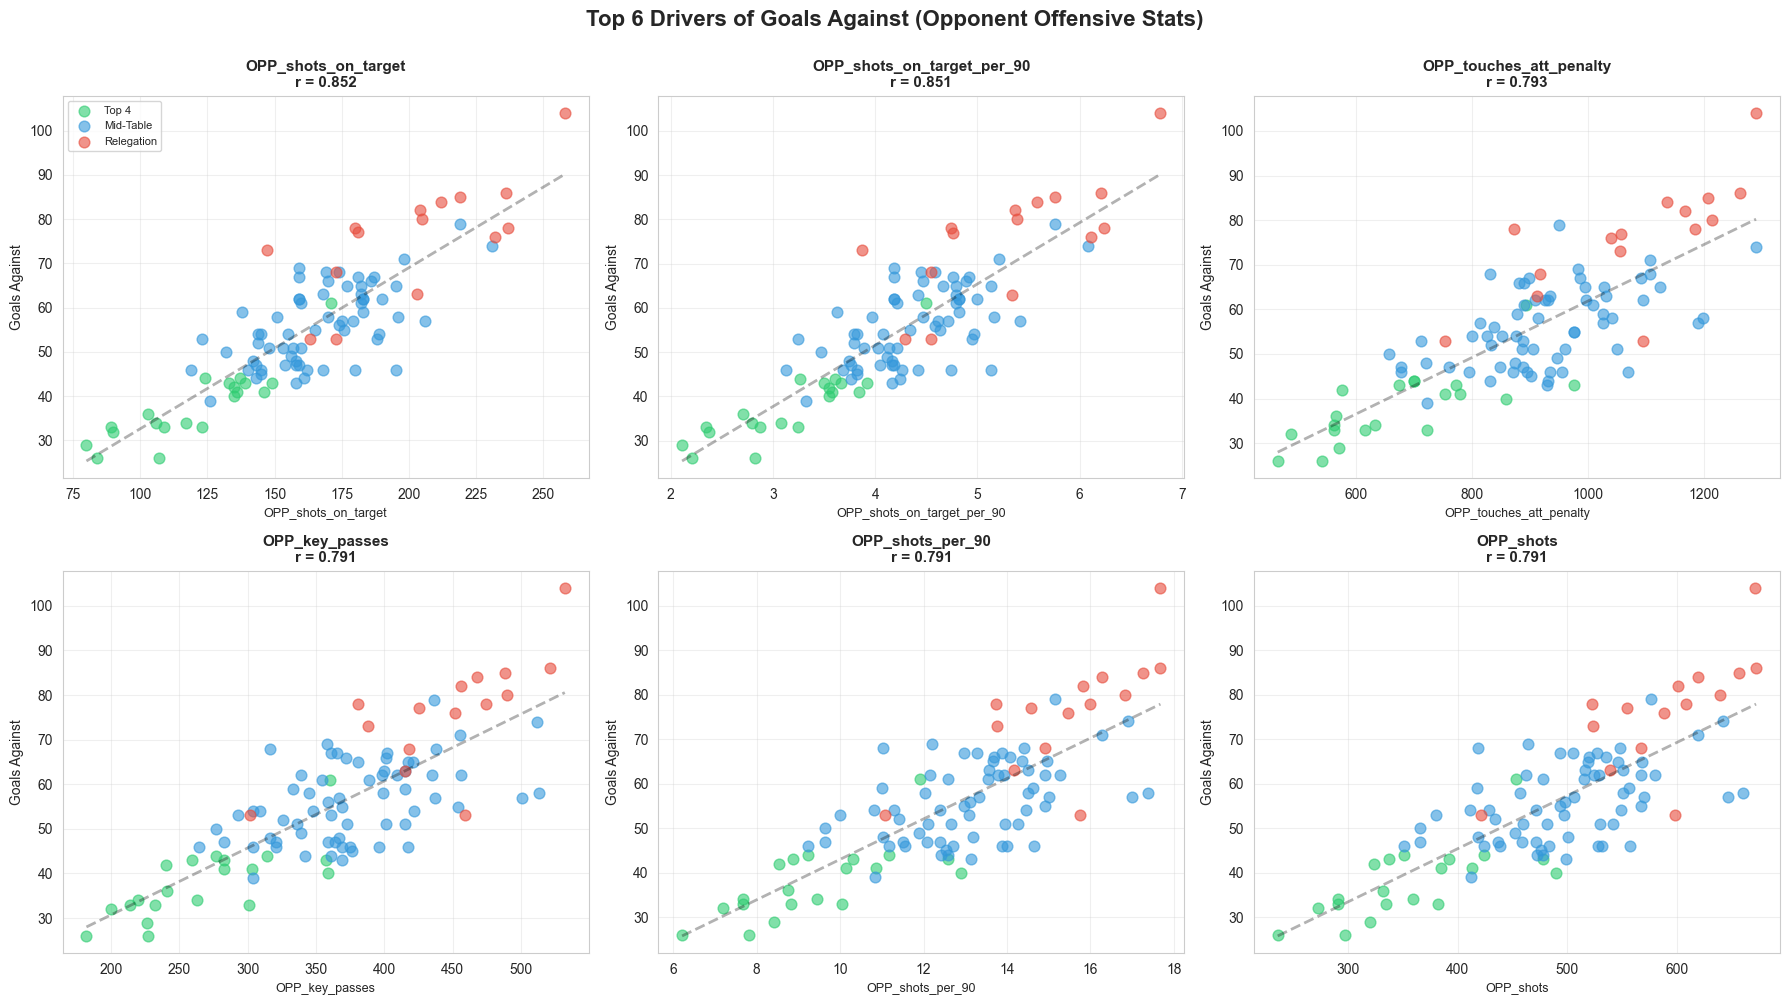

In [9]:
# Create scatter plots for top 6 defensive drivers
top_def_drivers = defense_df.head(6)['stat'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, opp_stat in enumerate(top_def_drivers):
    ax = axes[idx]
    base_stat = opp_stat.replace('OPP_', '')
    
    if base_stat not in merged_opp.columns:
        continue
    
    # Plot by tier
    for tier in ['Top 4', 'Mid-Table', 'Relegation']:
        data = merged_opp[merged_opp['tier'] == tier]
        ax.scatter(data[base_stat], data['goals_against'], 
                  label=tier, alpha=0.6, s=60, color=tier_colors[tier])
    
    # Add regression line
    valid = merged_opp[[base_stat, 'goals_against']].dropna()
    if len(valid) > 0 and valid[base_stat].std() > 0:
        z = np.polyfit(valid[base_stat], valid['goals_against'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(valid[base_stat].min(), valid[base_stat].max(), 100)
        ax.plot(x_line, p(x_line), 'k--', alpha=0.3, linewidth=2)
    
    # Get correlation
    r_val = defense_df[defense_df['stat'] == opp_stat]['r'].iloc[0]
    
    ax.set_xlabel(opp_stat, fontsize=9)
    ax.set_ylabel('Goals Against', fontsize=10)
    ax.set_title(f'{opp_stat}\nr = {r_val:.3f}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    if idx == 0:
        ax.legend(loc='best', fontsize=8)

plt.suptitle('Top 6 Drivers of Goals Against (Opponent Offensive Stats)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "scatter_defensive_drivers.png", dpi=300, bbox_inches='tight')
print("✅ Saved: scatter_defensive_drivers.png")
plt.show()

## Section 8: Tier-Based Analysis

### 8.1 Different Tiers, Different Drivers

In [10]:
# Calculate correlations by tier
def tier_correlations(tier_name):
    tier_data = squad_df[squad_df['tier'] == tier_name]
    results = []
    
    for stat in predictors:
        valid = tier_data[[stat, 'goals']].dropna()
        if len(valid) < 5 or valid[stat].std() == 0:
            continue
        r, p = pearsonr(valid[stat], valid['goals'])
        results.append({'stat': stat, 'r': r, 'p': p, 'abs_r': abs(r)})
    
    return pd.DataFrame(results).sort_values('abs_r', ascending=False)

top4_corr = tier_correlations('Top 4')
relegation_corr = tier_correlations('Relegation')

print("=" * 80)
print("TIER-BASED DRIVER ANALYSIS")
print("=" * 80)
print()
print("🏆 TOP 4 TEAMS - Top 5 Drivers:")
print("-" * 80)
for i, (idx, row) in enumerate(top4_corr.head(5).iterrows(), 1):
    print(f"{i}. {row['stat']:<45} r = {row['r']:>6.3f}")
print()

print("⚠️  RELEGATION TEAMS - Top 5 Drivers:")
print("-" * 80)
for i, (idx, row) in enumerate(relegation_corr.head(5).iterrows(), 1):
    print(f"{i}. {row['stat']:<45} r = {row['r']:>6.3f}")
print()

TIER-BASED DRIVER ANALYSIS

🏆 TOP 4 TEAMS - Top 5 Drivers:
--------------------------------------------------------------------------------
1. points                                        r =  0.924
2. goal_difference                               r =  0.920
3. final_position                                r = -0.799
4. passes_final_third                            r =  0.783
5. clearances                                    r = -0.781

⚠️  RELEGATION TEAMS - Top 5 Drivers:
--------------------------------------------------------------------------------
1. shots_on_target_per_90                        r =  0.846
2. shots_on_target                               r =  0.846
3. blocked_passes                                r =  0.763
4. shot_accuracy                                 r =  0.696
5. shots_per_90                                  r =  0.626



### 8.2 Visualize Tier Differences

✅ Saved: tier_comparison.png


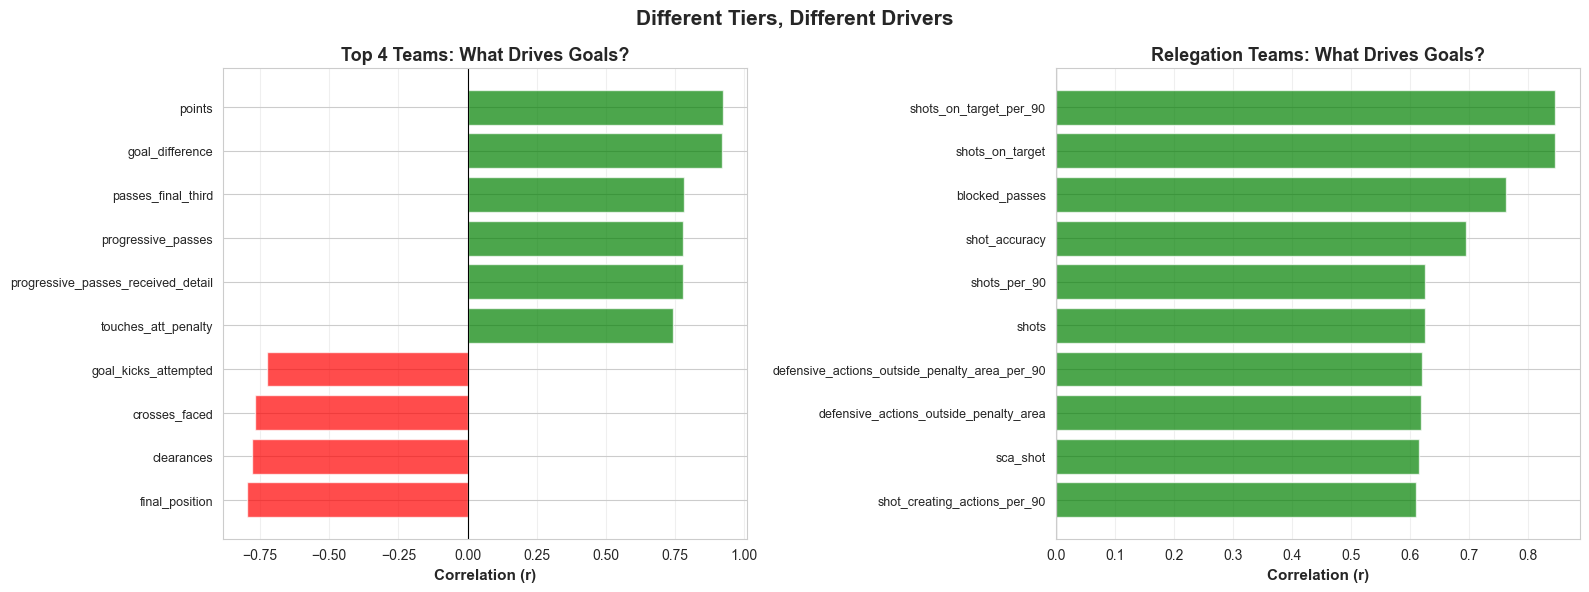

In [11]:
# Compare top drivers between tiers
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 4 drivers
ax = axes[0]
top_stats = top4_corr.head(10).sort_values('r', ascending=True)
colors_t4 = ['green' if r > 0 else 'red' for r in top_stats['r']]
ax.barh(range(len(top_stats)), top_stats['r'], color=colors_t4, alpha=0.7)
ax.set_yticks(range(len(top_stats)))
ax.set_yticklabels(top_stats['stat'], fontsize=9)
ax.set_xlabel('Correlation (r)', fontsize=11, fontweight='bold')
ax.set_title('Top 4 Teams: What Drives Goals?', fontsize=13, fontweight='bold')
ax.axvline(0, color='black', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

# Relegation drivers
ax = axes[1]
rel_stats = relegation_corr.head(10).sort_values('r', ascending=True)
colors_rel = ['green' if r > 0 else 'red' for r in rel_stats['r']]
ax.barh(range(len(rel_stats)), rel_stats['r'], color=colors_rel, alpha=0.7)
ax.set_yticks(range(len(rel_stats)))
ax.set_yticklabels(rel_stats['stat'], fontsize=9)
ax.set_xlabel('Correlation (r)', fontsize=11, fontweight='bold')
ax.set_title('Relegation Teams: What Drives Goals?', fontsize=13, fontweight='bold')
ax.axvline(0, color='black', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

plt.suptitle('Different Tiers, Different Drivers', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "tier_comparison.png", dpi=300, bbox_inches='tight')
print("✅ Saved: tier_comparison.png")
plt.show()

## Section 9: Statistical Significance

### 9.1 Test Correlation Robustness

In [12]:
# Add significance markers
def sig_marker(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

goals_df['sig'] = goals_df['p'].apply(sig_marker)

# Count by significance level
sig_counts = goals_df['sig'].value_counts()
total = len(goals_df)

print("=" * 80)
print("STATISTICAL SIGNIFICANCE TESTING")
print("=" * 80)
print()
print(f"Total correlations tested: {total}")
print(f"  *** (p < 0.001): {sig_counts.get('***', 0):3} ({100*sig_counts.get('***', 0)/total:.1f}%)")
print(f"  **  (p < 0.01):  {sig_counts.get('**', 0):3} ({100*sig_counts.get('**', 0)/total:.1f}%)")
print(f"  *   (p < 0.05):  {sig_counts.get('*', 0):3} ({100*sig_counts.get('*', 0)/total:.1f}%)")
print(f"  ns  (p ≥ 0.05):  {sig_counts.get('ns', 0):3} ({100*sig_counts.get('ns', 0)/total:.1f}%)")
print()

# Strong + significant
strong_sig = goals_df[(goals_df['abs_r'] >= 0.6) & (goals_df['p'] < 0.001)]
print(f"🎯 Strong + highly significant (|r| ≥ 0.6, p < 0.001): {len(strong_sig)}/{total}")
print()

# Save correlations to CSV
goals_df.to_csv(OUTPUT_DIR / "goals_scored_correlations.csv", index=False)
defense_df['sig'] = defense_df['p'].apply(sig_marker)
defense_df.to_csv(OUTPUT_DIR / "goals_against_correlations.csv", index=False)
print("✅ Saved: goals_scored_correlations.csv")
print("✅ Saved: goals_against_correlations.csv")

STATISTICAL SIGNIFICANCE TESTING

Total correlations tested: 128
  *** (p < 0.001):  73 (57.0%)
  **  (p < 0.01):   14 (10.9%)
  *   (p < 0.05):   11 (8.6%)
  ns  (p ≥ 0.05):   30 (23.4%)

🎯 Strong + highly significant (|r| ≥ 0.6, p < 0.001): 49/128

✅ Saved: goals_scored_correlations.csv
✅ Saved: goals_against_correlations.csv


### 9.2 Volcano Plot (Strength vs Significance)

✅ Saved: statistical_significance.png


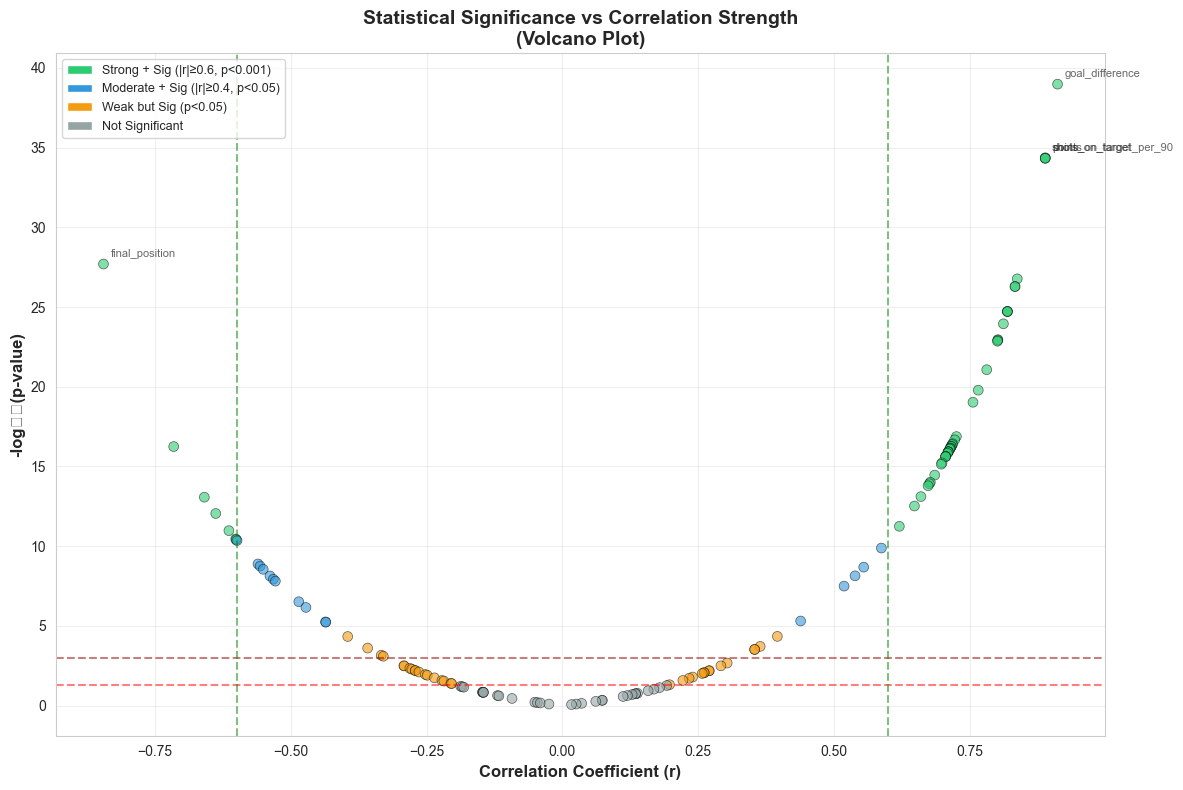

In [13]:
# Volcano plot
fig, ax = plt.subplots(figsize=(12, 8))

# Calculate -log10(p) for y-axis
goals_df['-log10_p'] = -np.log10(goals_df['p'])

# Color by strength + significance
def get_color(row):
    if row['abs_r'] >= 0.6 and row['p'] < 0.001:
        return '#2ecc71'  # Strong + highly significant
    elif row['abs_r'] >= 0.4 and row['p'] < 0.05:
        return '#3498db'  # Moderate + significant
    elif row['p'] < 0.05:
        return '#f39c12'  # Weak but significant
    else:
        return '#95a5a6'  # Not significant

goals_df['color'] = goals_df.apply(get_color, axis=1)

# Scatter plot
scatter = ax.scatter(goals_df['r'], goals_df['-log10_p'], 
                    c=goals_df['color'], s=50, alpha=0.6, edgecolors='black', linewidth=0.5)

# Add threshold lines
ax.axhline(-np.log10(0.05), color='red', linestyle='--', alpha=0.5, label='p = 0.05')
ax.axhline(-np.log10(0.001), color='darkred', linestyle='--', alpha=0.5, label='p = 0.001')
ax.axvline(0.6, color='green', linestyle='--', alpha=0.5, label='|r| = 0.6')
ax.axvline(-0.6, color='green', linestyle='--', alpha=0.5)

# Labels for top stats
top_labeled = goals_df.nlargest(5, 'abs_r')
for idx, row in top_labeled.iterrows():
    ax.annotate(row['stat'], (row['r'], row['-log10_p']), 
               fontsize=8, alpha=0.7, xytext=(5, 5), textcoords='offset points')

ax.set_xlabel('Correlation Coefficient (r)', fontsize=12, fontweight='bold')
ax.set_ylabel('-log₁₀(p-value)', fontsize=12, fontweight='bold')
ax.set_title('Statistical Significance vs Correlation Strength\n(Volcano Plot)', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='Strong + Sig (|r|≥0.6, p<0.001)'),
    Patch(facecolor='#3498db', label='Moderate + Sig (|r|≥0.4, p<0.05)'),
    Patch(facecolor='#f39c12', label='Weak but Sig (p<0.05)'),
    Patch(facecolor='#95a5a6', label='Not Significant')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "statistical_significance.png", dpi=300, bbox_inches='tight')
print("✅ Saved: statistical_significance.png")
plt.show()

## Section 10: Summary Report

In [14]:
# Generate comprehensive summary report
print("=" * 80)
print("GENERATING SUMMARY REPORT")
print("=" * 80)
print()

summary_path = OUTPUT_DIR / "summary_report.txt"

with open(summary_path, 'w') as f:
    f.write("=" * 100 + "\n")
    f.write("PART 1D: ROOT CAUSE ANALYSIS - WHAT DRIVES GOALS?\n")
    f.write("=" * 100 + "\n\n")
    
    f.write("DESIGN:\n")
    f.write("- Analysis 1: What drives OUR goals scored\n")
    f.write("- Analysis 2: What drives goals AGAINST us (opponent offensive actions)\n\n")
    
    f.write("=" * 100 + "\n")
    f.write("RESULTS\n")
    f.write("=" * 100 + "\n\n")
    
    f.write("TOP 10 DRIVERS OF GOALS SCORED:\n")
    for i, (idx, row) in enumerate(goals_df.head(10).iterrows(), 1):
        f.write(f"   {i:2}. {row['stat']:<45} r = {row['r']:>6.3f}\n")
    
    f.write("\nTOP 20 DRIVERS OF GOALS AGAINST:\n")
    for i, (idx, row) in enumerate(defense_df.head(20).iterrows(), 1):
        f.write(f"   {i:2}. {row['stat']:<45} r = {row['r']:>6.3f}\n")
    
    f.write("\n" + "=" * 100 + "\n")
    f.write("CATEGORY ANALYSIS\n")
    f.write("=" * 100 + "\n\n")
    f.write(category_stats.to_string())
    
    f.write("\n\n" + "=" * 100 + "\n")
    f.write("TIER COMPARISON\n")
    f.write("=" * 100 + "\n\n")
    
    f.write("TOP 4 TEAMS - Top 5 Drivers:\n")
    for i, (idx, row) in enumerate(top4_corr.head(5).iterrows(), 1):
        f.write(f"  {row['stat']:<45} r = {row['r']:>6.3f}\n")
    
    f.write("\nRELEGATION TEAMS - Top 5 Drivers:\n")
    for i, (idx, row) in enumerate(relegation_corr.head(5).iterrows(), 1):
        f.write(f"  {row['stat']:<45} r = {row['r']:>6.3f}\n")
    
    f.write("\n\n" + "=" * 100 + "\n")
    f.write("STATISTICAL SIGNIFICANCE\n")
    f.write("=" * 100 + "\n\n")
    
    sig_total = sig_counts.get('***', 0) + sig_counts.get('**', 0) + sig_counts.get('*', 0)
    f.write(f"Significant correlations (p<0.05): {sig_total}/{total}\n")
    f.write(f"Strong + significant (|r|≥0.6, p<0.001): {len(strong_sig)}/{total}\n\n")
    
    f.write("\n" + "=" * 100 + "\n")
    f.write("APPLICATIONS\n")
    f.write("=" * 100 + "\n")
    f.write("1. COMPOSITE WEIGHTS: Use |r| to weight stats in composites\n")
    f.write("2. MATCH PREDICTION: Model both sides:\n")
    f.write("   - Our goals = f(our offense)\n")
    f.write("   - Their goals = f(their offense)\n")
    f.write("   - Adjust for opponent defensive quality\n")

print(f"✅ Saved comprehensive summary: {summary_path}")
print()

# Close database connection
conn.close()

print("=" * 80)
print("✅ PART 1D: ROOT CAUSE ANALYSIS COMPLETE")
print("=" * 80)
print()
print(f"📂 All outputs saved to: {OUTPUT_DIR}")
print()
print("📊 Files created:")
print("   - goals_scored_correlations.csv")
print("   - goals_against_correlations.csv")
print("   - scatter_offensive_drivers.png")
print("   - scatter_defensive_drivers.png")
print("   - category_correlations.png")
print("   - tier_comparison.png")
print("   - statistical_significance.png")
print("   - summary_report.txt")
print()
print("🎯 Key Takeaways:")
print(f"   - {len(strong_sig)} stats strongly predict goals (|r|≥0.6, p<0.001)")
print(f"   - {category_stats.index[0]} is the strongest category (avg r = {category_stats.iloc[0]['avg_r']:.3f})")
print("   - Top 4 vs Relegation teams have DIFFERENT goal drivers")
print("   - Opponent offense strongly predicts our goals against")
print()
print("🚀 Next: Use these correlations for match prediction and composite weighting")

GENERATING SUMMARY REPORT

✅ Saved comprehensive summary: ../../outputs/04_individual_stats/summary_report.txt

✅ PART 1D: ROOT CAUSE ANALYSIS COMPLETE

📂 All outputs saved to: ../../outputs/04_individual_stats

📊 Files created:
   - goals_scored_correlations.csv
   - goals_against_correlations.csv
   - scatter_offensive_drivers.png
   - scatter_defensive_drivers.png
   - category_correlations.png
   - tier_comparison.png
   - statistical_significance.png
   - summary_report.txt

🎯 Key Takeaways:
   - 49 stats strongly predict goals (|r|≥0.6, p<0.001)
   - attacking_output is the strongest category (avg r = 0.680)
   - Top 4 vs Relegation teams have DIFFERENT goal drivers
   - Opponent offense strongly predicts our goals against

🚀 Next: Use these correlations for match prediction and composite weighting
